In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

phoenixrose07_deepfake_path = kagglehub.dataset_download('phoenixrose07/deepfake')

print('Data source import complete.')


100%|██████████| 1.68G/1.68G [00:17<00:00, 105MB/s]

Extracting files...


Data source import complete.


In [4]:
print(phoenixrose07_deepfake_path)

/root/.cache/kagglehub/datasets/phoenixrose07/deepfake/versions/1


In [4]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#getting all the import statements
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import random
import time
import os
from collections import Counter
import pandas as pd
import numpy as np
import PIL
import timm

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec  7 16:55:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
train_dir = "/root/.cache/kagglehub/datasets/phoenixrose07/deepfake/versions/1/Train"
val_dir = "/root/.cache/kagglehub/datasets/phoenixrose07/deepfake/versions/1/Validation"
test_dir = "/root/.cache/kagglehub/datasets/phoenixrose07/deepfake/versions/1/Test"

In [7]:
#augument the data when needed
#applying a simple transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)

In [9]:
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=True)

In [10]:
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=500, shuffle=True)

In [11]:
#class distribution in the train_dataset
print(f"Classes: {train_dataset.classes}")

Classes: ['Fake', 'Real']


In [12]:
LABELS = train_dataset.classes

In [13]:
#check distribution
train_classes = [train_dataset.targets[i] for i in range(len(train_dataset))]
print("Class distribution in training set:", Counter(train_classes))

Class distribution in training set: Counter({0: 70001, 1: 70001})


Batch size: torch.Size([500, 3, 224, 224])


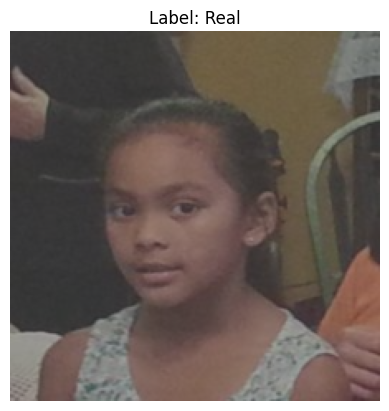

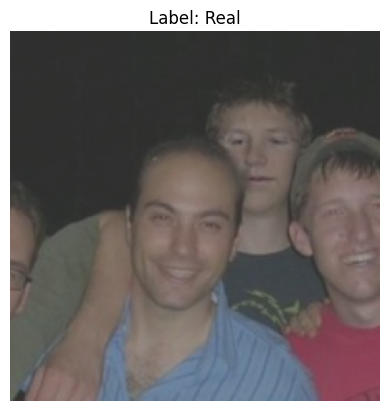

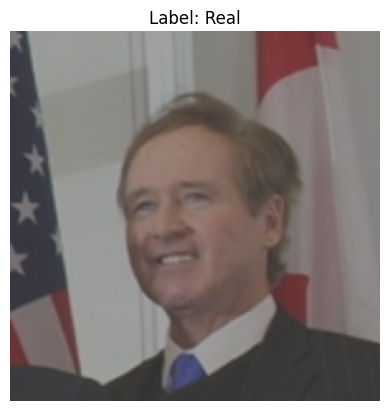

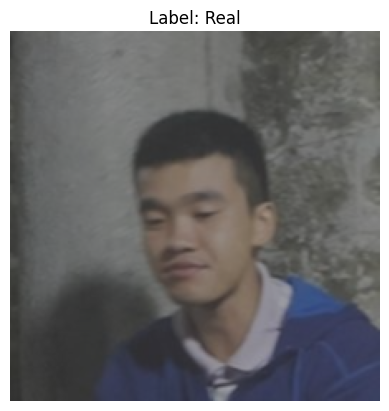

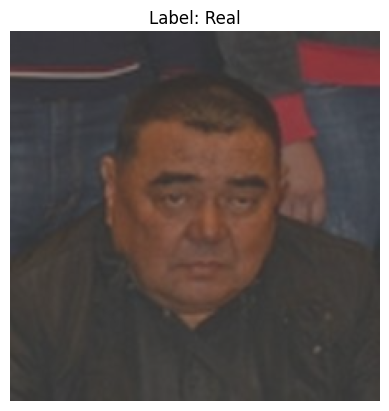

In [14]:
data_iter = iter(train_dataloader)
images, labels = next(data_iter)
print("Batch size:", images.shape)


#displaying the first 5 images
for i in range(5):
    #denormalization
    plt.imshow(images[i].permute(1, 2, 0).numpy() * 0.225 + 0.406)
    plt.title(f"Label: {LABELS[labels[i]]}")
    plt.axis("off")
    plt.show()

In [14]:
# # Path to your training dataset
# train_dir = "/kaggle/input/deepfake/Train"

# # Check number of files per class
# def count_files_per_class(dataset):
#     class_counts = Counter(dataset.targets)
#     class_names = dataset.classes
#     counts_per_class = {class_names[idx]: count for idx, count in class_counts.items()}
#     return counts_per_class

# # Load the dataset without augmentation
# dataset_without_aug = ImageFolder(root=train_dir)

# # Print class counts before augmentation
# print("Class Distribution in Training Dataset:")
# class_counts = count_files_per_class(dataset_without_aug)
# for class_name, count in class_counts.items():
#     print(f"Class '{class_name}': {count} images")

In [21]:
import torch.nn as nn
from torchvision import models
from timm import create_model

model = create_model('convnext_tiny', pretrained=True)

# Get the number of features in the last layer
n_features = model.head.fc.in_features

# Replace the classification head with a custom layer
# Adding a linear layer for binary classification with a sigmoid activation
model.head.fc = nn.Sequential(
    nn.Linear(n_features, 1),
    nn.Sigmoid()
)


In [22]:
model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [23]:
# Move model to GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cuda')

In [24]:
#feature extraction phase
#freezing the previous layers to prevent backpropogation
for param in model.parameters():
    param.requires_grad = False
#unfreezing the last layers to allow backpropogation
for param in model.head.fc.parameters():
    param.requires_grad = True

In [25]:
criterion = nn.BCELoss()
#optimizer = Adam, with learning rate =0.001
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

In [26]:
torch.cuda.empty_cache()

In [27]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #For sigmoid: >0.5=1 else 0
        predicted = (outputs > 0.5).int()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)

    #setting model to validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    #witout computing gradients
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs > 0.5).int()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/5, Train Loss: 0.4509, Train Acc: 78.49%, Val Loss: 0.4116, Val Acc: 81.12%
Epoch 2/5, Train Loss: 0.4068, Train Acc: 81.26%, Val Loss: 0.4099, Val Acc: 81.27%
Epoch 3/5, Train Loss: 0.4002, Train Acc: 81.80%, Val Loss: 0.4283, Val Acc: 80.27%
Epoch 4/5, Train Loss: 0.3983, Train Acc: 81.75%, Val Loss: 0.4172, Val Acc: 80.88%
Epoch 5/5, Train Loss: 0.3943, Train Acc: 82.08%, Val Loss: 0.4267, Val Acc: 80.33%


In [28]:
torch.save(model.state_dict(), "model.pth")

In [31]:
# Put the model in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():  # No gradient computation for evaluation
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().view(-1, 1)  # Reshape for BCE loss
        outputs = model(inputs)

        # Apply threshold to get binary predictions
        predicted = (outputs > 0.5).int()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


              precision    recall  f1-score   support

        Fake       0.69      0.87      0.77      5492
        Real       0.81      0.60      0.69      5413

    accuracy                           0.73     10905
   macro avg       0.75      0.73      0.73     10905
weighted avg       0.75      0.73      0.73     10905



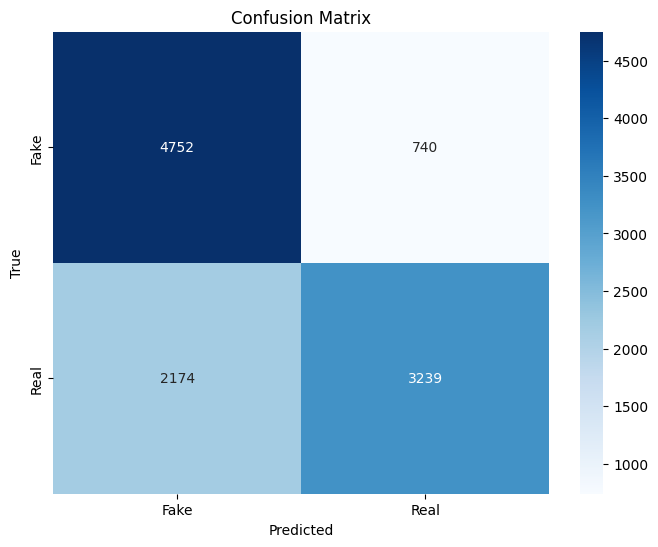

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

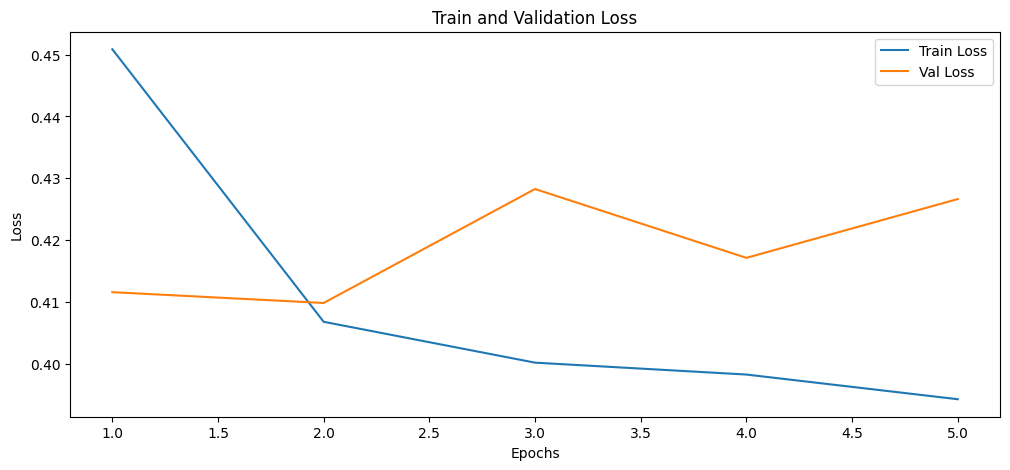

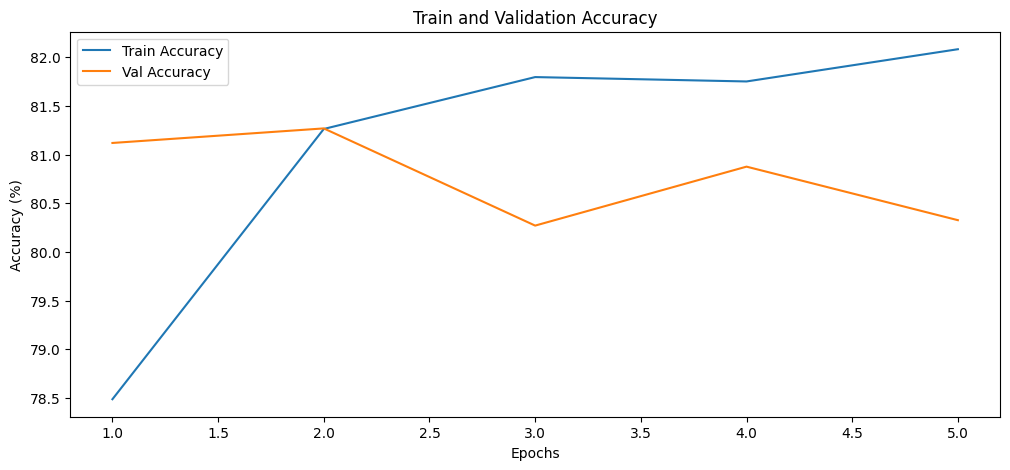

In [29]:
# Plot losses
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [36]:
#freezing the previous layers to prevent backpropogation
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

In [37]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #For sigmoid: >0.5=1 else 0
        predicted = (outputs > 0.5).int()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)

    #setting model to validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    #witout computing gradients
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs > 0.5).int()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/2, Train Loss: 0.3951, Train Acc: 82.00%, Val Loss: 0.4067, Val Acc: 81.52%
Epoch 2/2, Train Loss: 0.3921, Train Acc: 82.18%, Val Loss: 0.4032, Val Acc: 81.72%


In [38]:
# Put the model in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():  # No gradient computation for evaluation
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().view(-1, 1)  # Reshape for BCE loss
        outputs = model(inputs)

        # Apply threshold to get binary predictions
        predicted = (outputs > 0.5).int()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


              precision    recall  f1-score   support

        Fake       0.73      0.80      0.77      5492
        Real       0.78      0.70      0.74      5413

    accuracy                           0.75     10905
   macro avg       0.76      0.75      0.75     10905
weighted avg       0.76      0.75      0.75     10905



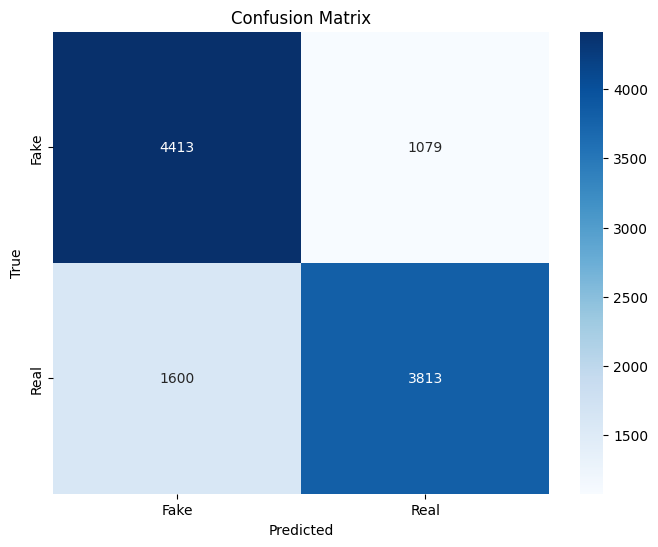

In [39]:

print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [62]:
torch.save(model.state_dict(), "model1.pth")

In [63]:
all_preds

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [64]:
all_labels

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [ ]:
!pip install lime
import numpy as np
import torch
from torchvision import models, transforms
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt


Loaded Image shape: (256, 256, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

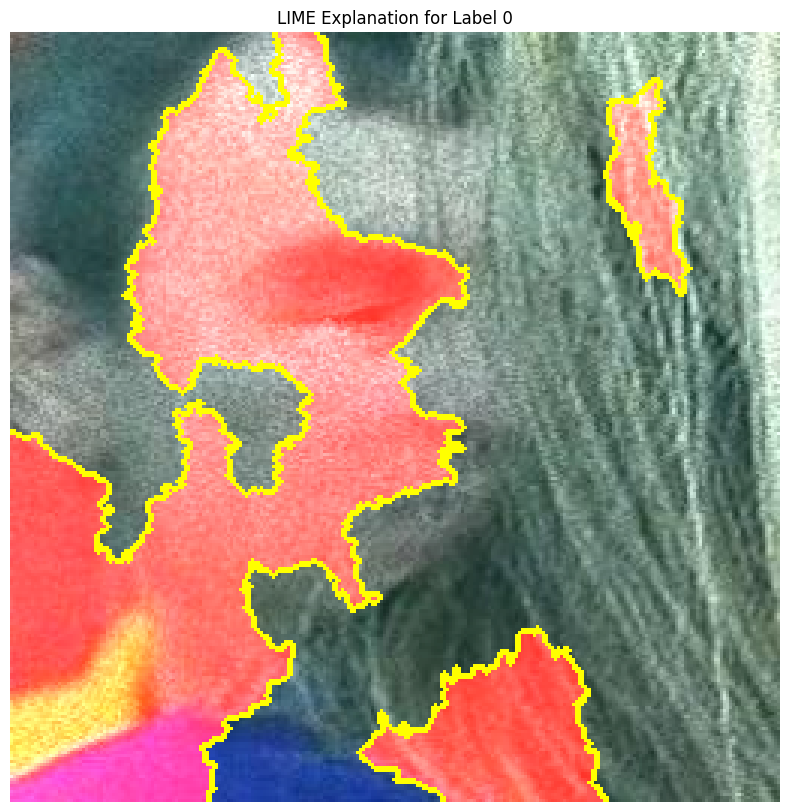

In [ ]:
from PIL import Image
model.eval()

#preproccessing the image
def preprocess_image(img):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(img)

#pred function
def predict(images):
    inputs = torch.stack([preprocess_image(Image.fromarray(image)) for image in images]).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        probabilities = outputs.cpu().numpy()
    return probabilities

#getting an image
image_path = "/content/fake_11.jpg"
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)

print("Loaded Image shape:", img_np.shape)

#Lime
explainer = LimeImageExplainer()

#explaination
explanation = explainer.explain_instance(
     img_np,
    predict,
    top_labels=1,
    num_features=1000,  # Try a higher number of features for better segmentation
    hide_color=0,
    batch_size=8   # Number of images to process in a batch
)

#top label explaination
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=False,
    num_features=10,
    hide_rest=False
)

#Visualization
plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation for Label {top_label}")
plt.axis("off")
plt.show()